# Data Reduction

Data reduction is the process of calibrating astronomical images. Its goal is to go from an image in which pixel values are raw counts to an image in which each value is the number of photons in that pixel.

There are potentially several steps in data reduction. Which ones are actually applied depends on the instrument used to take the images.

[Fill in list after lecture]

## Recipes for reduction

There are two formulae we will typically use for reducing images. Which one you use depends on whether you need to scale the dark frames by exposure time.

### Exposure time of dark *does not* match science or flat images

In this case, a bias frame should be subtracted separately from correcting for dark current. The frames used for correcting the dark current also need to have bias subtracted so that they can be scaled by exposure time without also scaling the bias level. If $D_{\text{sub bias}}$ is a bias-subtracted dark frame with exposure time $t_D$, $B$ is a bias frame, $F_{\text{calib}}$ is a *calibrated* flat frame, and $L_{\text{raw}}$ is an uncalibrated light frame with exposure time $t_L$, then

$$
L_{\text{calibrated}} = \frac{L_{\text{raw}} - B - (t_L/t_D) D_{\text{sub bias}}}{F_{\text{calib}}}
$$

### Exposure time of dark *does* match science image

$$
L_{\text{calibrated}} = \frac{L_{\text{raw}} - D_{\text{NO sub bias}}}{F_{\text{calib}}}
$$

# Reducing by hand

In this exercise you will reduce an image "by hand" to try out using the formulae above.

## Run the cell below, but do not modify

Nothing afterwards will work unless you run this cell.


In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd

import astropy.units as u
import astropy.coordinates as apycoord
from astropy.visualization import simple_norm
from astropy.nddata import block_replicate, block_reduce
from astropy.table import Table, Column, MaskedColumn
from astropy.time import Time

from ccdproc import CCDData, ImageFileCollection

from reducer.image_browser import ImageBrowser

from scipy import optimize

%matplotlib notebook
import matplotlib.pyplot as plt

# This function really should be somewhere else eventually.
def scale_and_downsample(data, downsample=1,
                         min_percent=20,
                         max_percent=99.5):

    norm = simple_norm(data,
                       min_percent=min_percent,
                       max_percent=max_percent)
    scaled_data = norm(data)
    if downsample > 1:
        scaled_data = block_reduce(scaled_data,
                                   block_size=(downsample, downsample))
    return scaled_data



## Put the directory of images in the same directory as your notebooks

It is easiest to do that using the Finder (Mac) or Windows Explorer (Windows).

The cells below read a directory (folder) of images and displays it.

In [2]:
collection = ImageFileCollection('Lab05_Reduce_by_Hand')

In [3]:
browser = ImageBrowser(collection, keys=['naxis2'])
browser.display()

ImageBrowser(children=(Accordion(children=(Box(children=(Select(layout=Layout(width='100%'), options=('biases_…

## The command below reads a single data file and then displays it

<IPython.core.display.Javascript object>


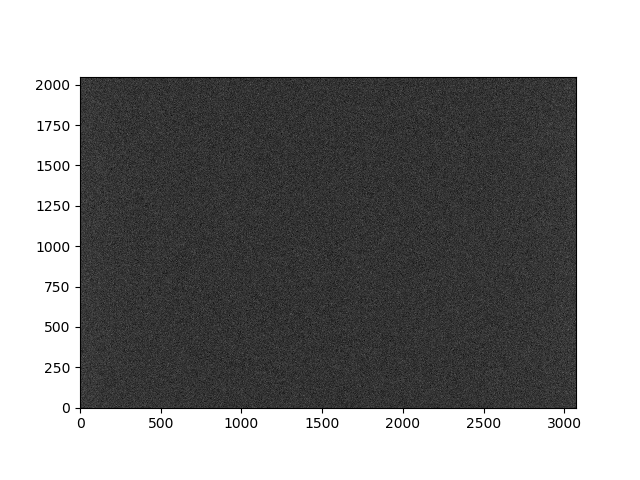

In [17]:
bias = CCDData.read('Lab05_Reduce_by_Hand/biases_median.fits', unit='adu')   #Read in a single fits image
plt.figure()
plt.imshow(bias.data, cmap='gray', origin='lower')

## It is better to scale the data first, as shown below 

<IPython.core.display.Javascript object>


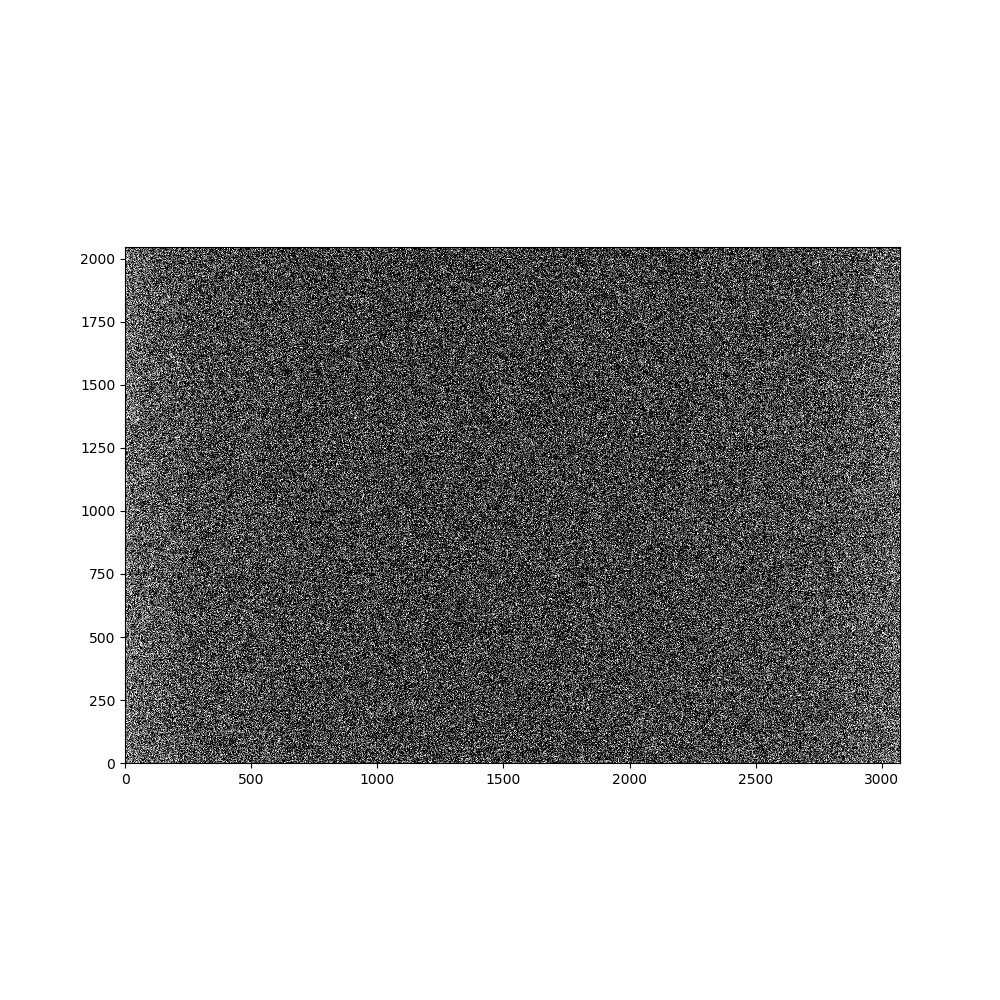

In [19]:
bias = CCDData.read('Lab05_Reduce_by_Hand/biases_median.fits', unit='adu')   #Read in a single fits image
plt.figure(figsize=(10, 10))
plt.imshow(scale_and_downsample(bias.data), cmap='gray', origin='lower')

## Image arithmetic

The cell below loads another image....

In [6]:
dark_5sec = CCDData.read('Lab05_Reduce_by_Hand/dark_frame_one_median.fits', unit='adu')

...and this cell calculates the difference between the loaded dark and bias.

In [7]:
dark_sub_bias_5 = dark_5sec.data - bias.data

Finally, this displays the subtracted data.

In [8]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(dark_5sec.data), cmap='gray')

<IPython.core.display.Javascript object>

In [9]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(dark_sub_bias_5), cmap='gray', origin='lower')

<IPython.core.display.Javascript object>

In [10]:
dark_sub_bias_5.min()

-49.5

In [11]:
flat = CCDData.read('Lab05_Reduce_by_Hand/flat_master_R.fits', unit='adu')

In [12]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(flat.data), cmap='gray', origin='lower')

<IPython.core.display.Javascript object>

In [13]:
light = CCDData.read('Lab05_Reduce_by_Hand/ey-uma-060R.fit', unit='adu')

In [14]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(light.data, downsample=1), cmap='gray')

<IPython.core.display.Javascript object>

In [15]:
dark_60sec = CCDData.read('Lab05_Reduce_by_Hand/dark_frame_two_median.fits', unit='adu')

<IPython.core.display.Javascript object>


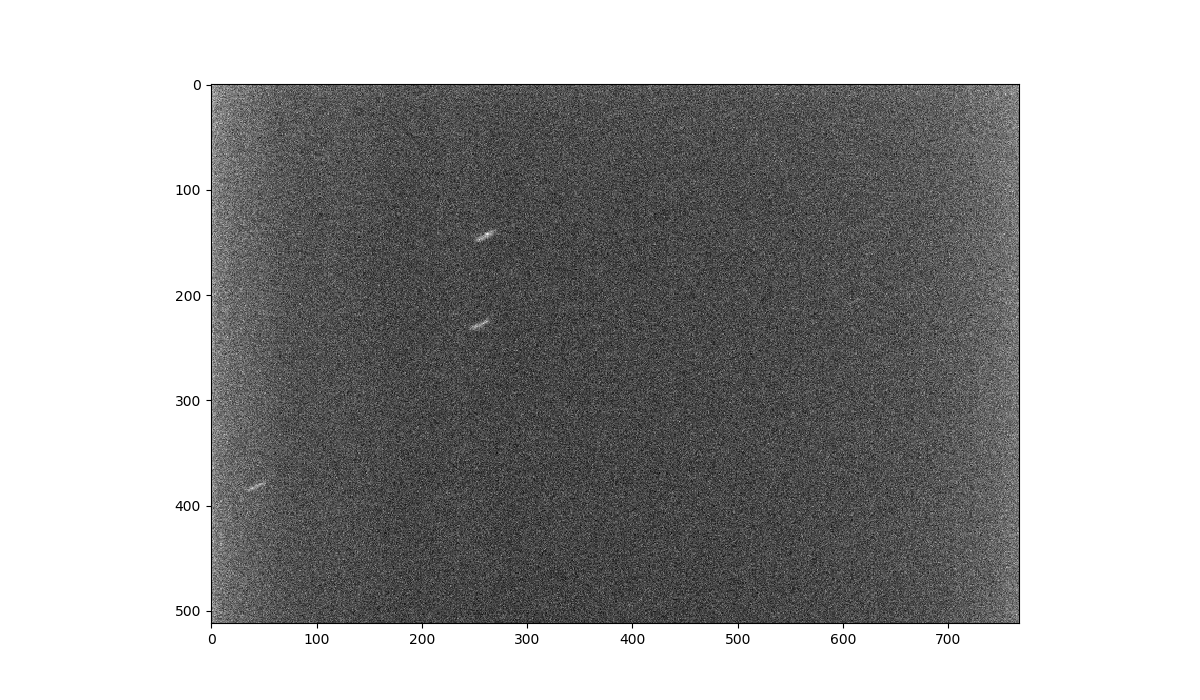

In [20]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(dark_60sec.data, downsample=4), cmap='gray')

In [21]:
dark_60sec_fudge = dark_60sec.copy()

In [22]:
def patch_spot(data, bottom, left, offset=-150):
    height = 100
    width = 200 
    horiz = slice(left, left + width)
    vert = slice(bottom, bottom + height)
    data[vert, horiz] = data[vert.start + offset:vert.stop + offset, horiz]

# dark_60sec_fudge.data[550:650, 980:1180] = dark_60sec_fudge.data[400:500, 980:1180]
patch_spot(dark_60sec_fudge.data, 550, 980)
patch_spot(dark_60sec_fudge.data, 880, 950, offset=150)
patch_spot(dark_60sec_fudge.data, 1510, 111, offset=-150)
patch_spot(dark_60sec_fudge.data, 790, 2440, offset=-150)

<IPython.core.display.Javascript object>


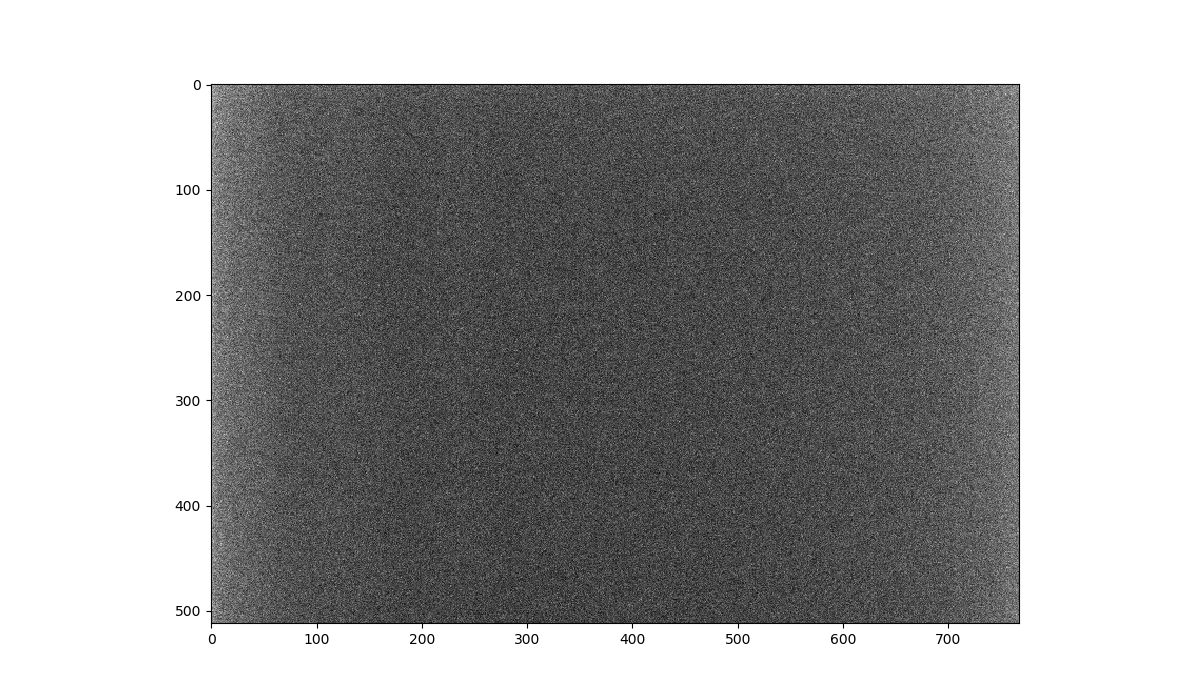

In [24]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(dark_60sec_fudge.data, downsample=4), cmap='gray')

In [25]:
dark_60sec_fudge.header['IMAGETYP'] = 'DARK'

In [ ]:
#dark_60sec_fudge.write('dark_fudged.fits')

In [26]:
first_try = (light.data - dark_60sec.data)/flat.data

<IPython.core.display.Javascript object>


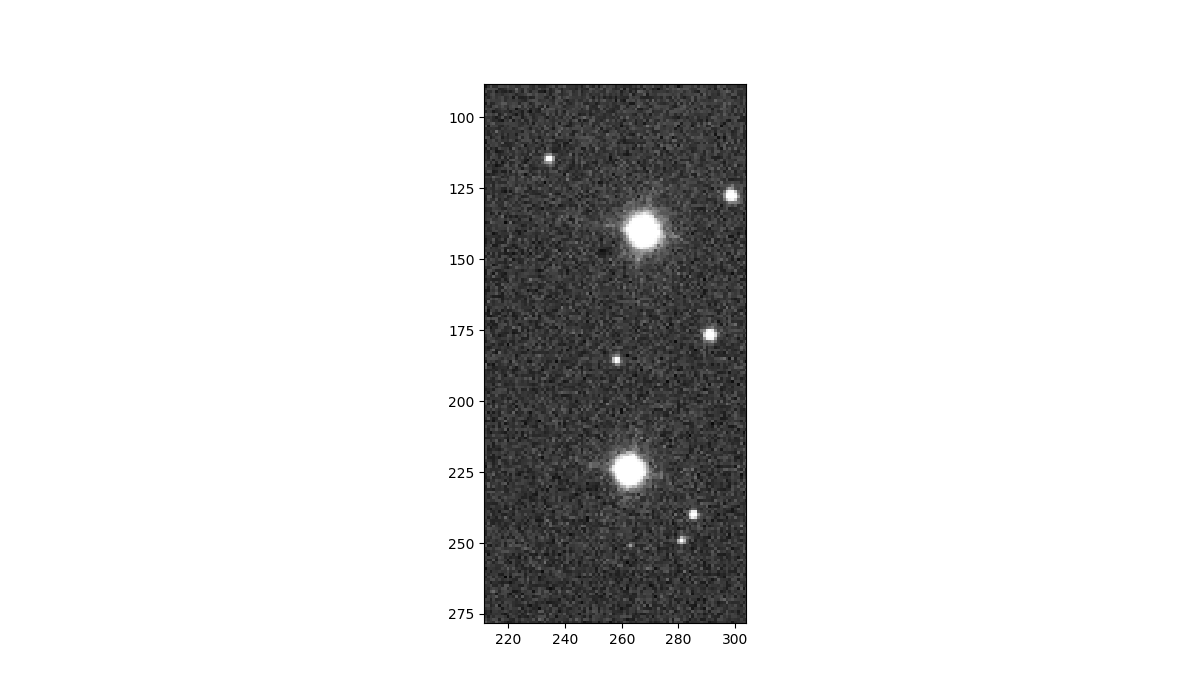

In [27]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(first_try, downsample=4), cmap='gray')

In [28]:
second_try = (light.data - bias.data - 60/5*(dark_5sec.data - bias.data))/flat.data

<IPython.core.display.Javascript object>


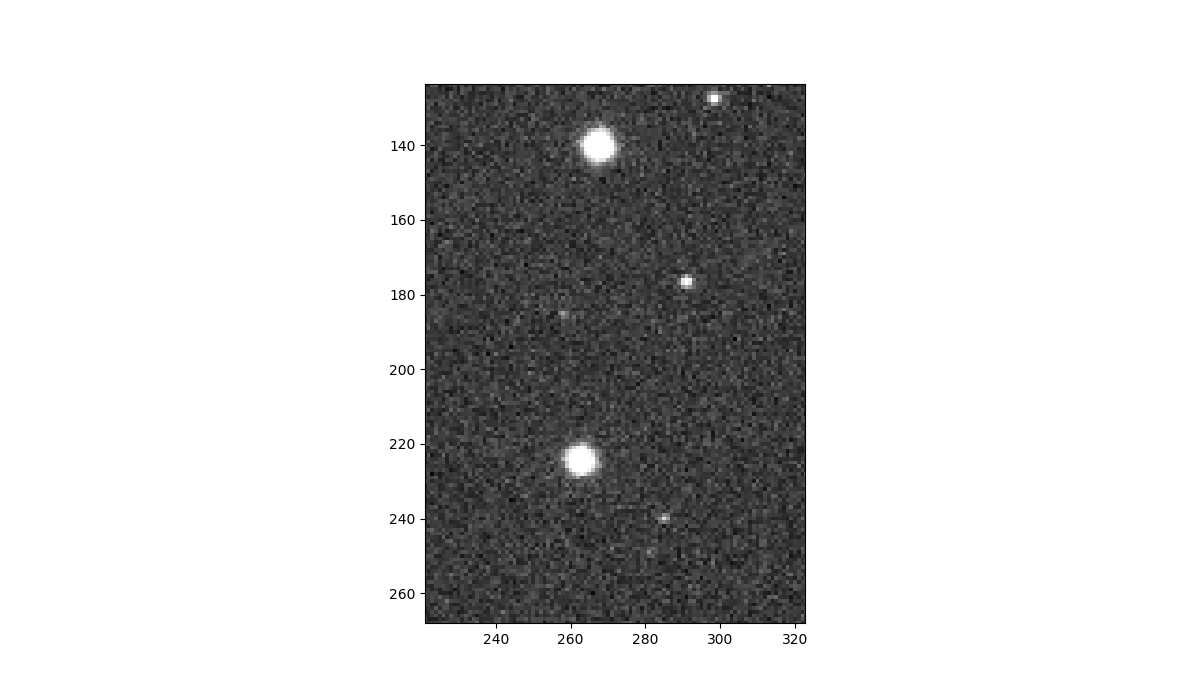

In [29]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(second_try, downsample=4), cmap='gray')

In [30]:
np.std(dark_5sec.data)

7.843239

In [31]:
np.std(bias.data)

7.578396

In [32]:
np.std(second_try)

309.22025

In [33]:
np.std(light.data[200:300, 200:300])

23.466316

In [34]:
np.std(dark_5sec.data - bias.data)

10.753457

In [35]:
np.std(second_try[200:300, 200:300])

123.91849

In [36]:
np.std(first_try[200:300, 200:300])

24.361807

In [37]:
sz_lyn = CCDData.read('Lab05_Reduce_by_Hand/sz-lyn-042R.fit', unit='adu')

<IPython.core.display.Javascript object>


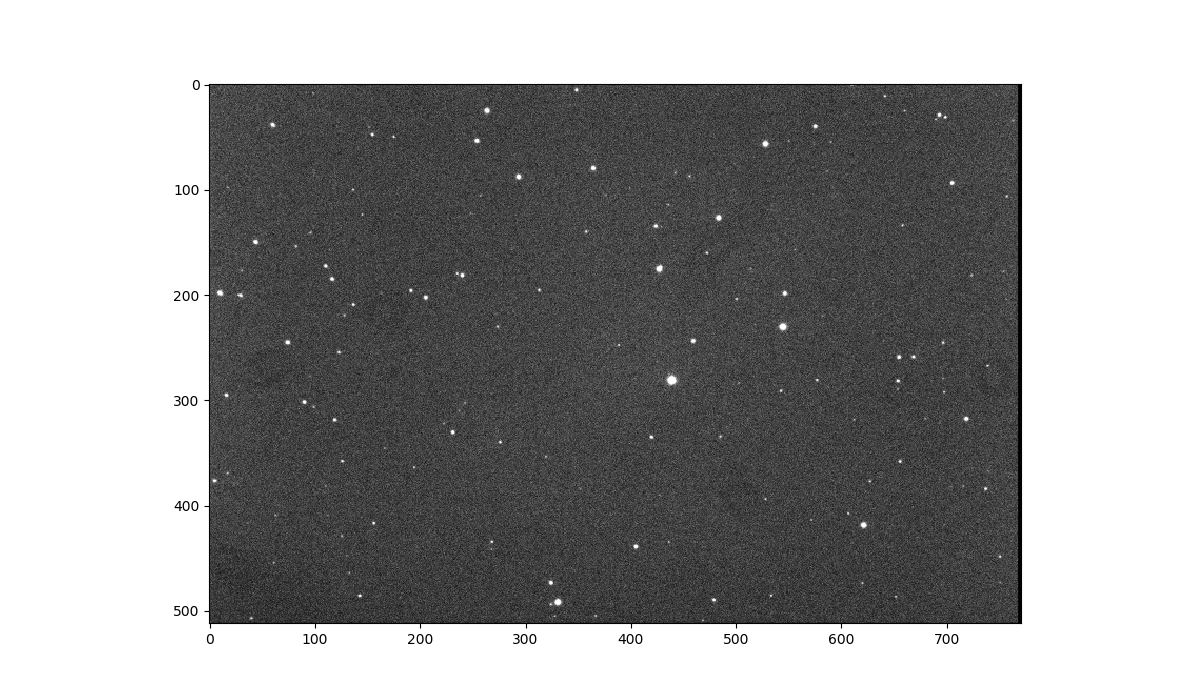

In [38]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(sz_lyn.data, downsample=4), cmap='gray')

In [45]:
sz_lyn_reduced = (sz_lyn.data[:,:3073] - bias.data - 45/60*(dark_60sec_fudge.data - bias.data))/flat.data

<IPython.core.display.Javascript object>


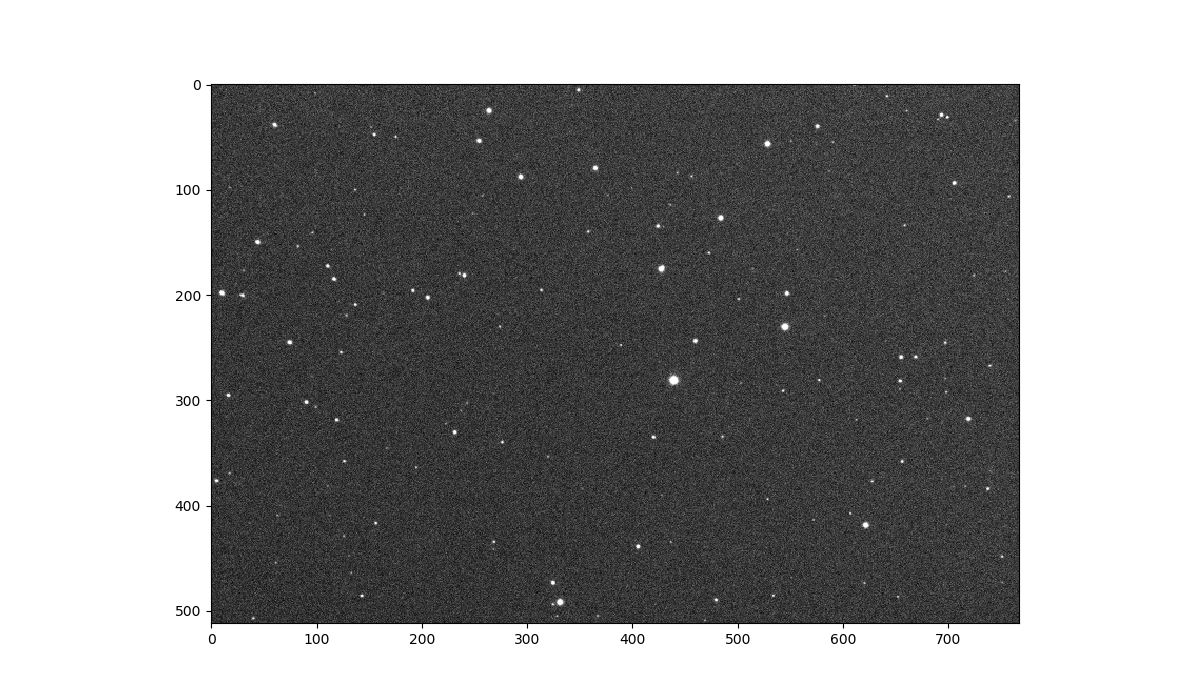

In [46]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(sz_lyn_reduced, downsample=4), cmap='gray')

In [40]:
sz_lyn_reduced2 = (sz_lyn.data[:,:3073] - bias.data - 45/5*(dark_5sec.data - bias.data))/flat.data

<IPython.core.display.Javascript object>


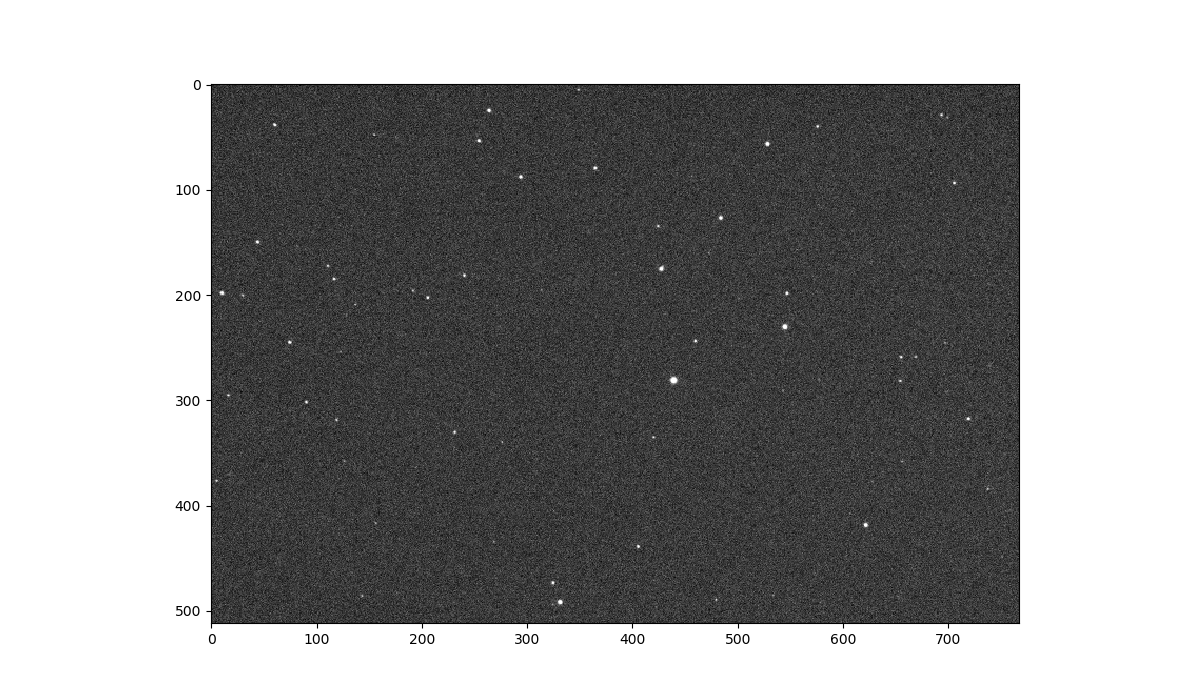

In [41]:
plt.figure(figsize=(12, 7))
plt.imshow(scale_and_downsample(sz_lyn_reduced2, downsample=4), cmap='gray')

<IPython.core.display.Javascript object>


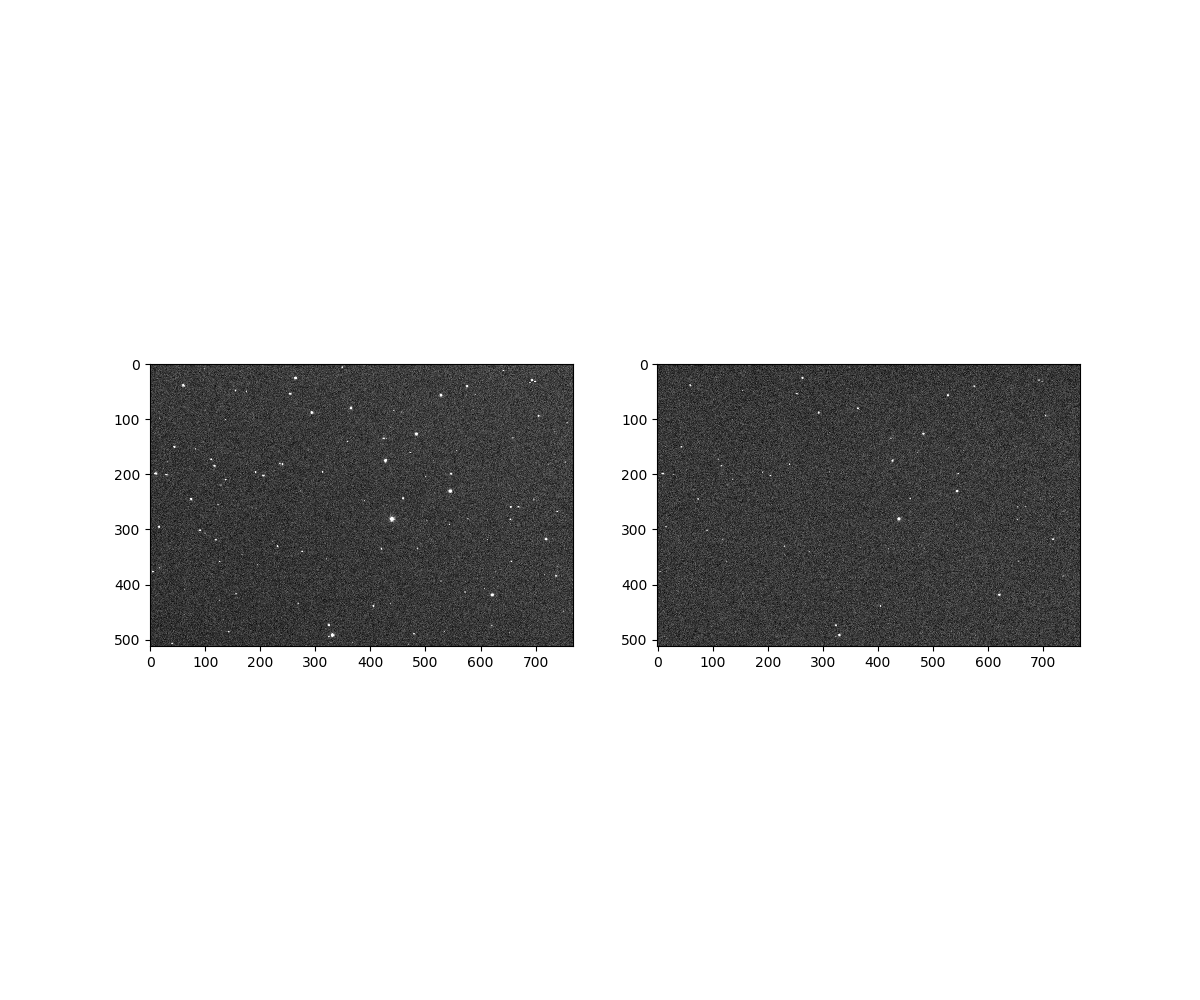

In [44]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,10), sharex=True)
#plt.figure(figsize=(12, 7))
#fig.set_figwidth(12)
ax1.imshow(scale_and_downsample(sz_lyn_reduced, downsample=4), cmap='gray')
ax2.imshow(scale_and_downsample(sz_lyn_reduced2, downsample=4), cmap='gray')

In [48]:
sz_ccd = CCDData(data=sz_lyn_reduced, header=sz_lyn.header, unit='adu')

In [49]:
sz_ccd.write('sz-lyn-042R-reduced.fit')